In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# reading in all the words
words = open('names.txt', 'r').read().splitlines()

In [3]:
# building the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)

In [4]:
# building the dataset
block_size = 3  # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [5]:
import random
random.seed(10)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])      # 80% (train set)
Xdev, Ydev = build_dataset(words[n1:n2])  # 10% (val/dev set)
Xte, Yte = build_dataset(words[n2:])      # 10% (test set)

In [6]:
# Defining the classes for the custom layers

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [7]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 400  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(573946)

# Embedding matrix for the vocabulary
C = torch.randn((vocab_size, n_embd), generator=g)

In [8]:
# Define the layers of the model
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

In [9]:
# Initialize parameters and define the gradient flag
parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

In [10]:
# Manual backpropagation setup
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5 / 3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

manual_parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in manual_parameters:
    p.requires_grad = True

# Training parameters
max_steps = 200000
batch_size = 32
lossi = []

In [11]:
# Training loop with both forward pass and manual backpropagation
for i in range(max_steps):

    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y

    # Forward pass with layers
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # Zero gradients for automatic backprop
    for p in parameters:
        p.grad = None

    # Backward pass
    loss.backward()

    # Update weights with gradient descent
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad

    # Manual backpropagation
    # Reset gradients
    for p in manual_parameters:
        p.grad = None

    # Forward pass manual
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hprebn = embcat @ W1 + b1
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss_manual = F.cross_entropy(logits, Yb)

    # Manual backpropagation gradients
    dlogits = F.softmax(logits, 1)
    dlogits[range(batch_size), Yb] -= 1
    dlogits /= batch_size

    # Layer 2 gradients
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)

    # Tanh gradients
    dhpreact = (1.0 - h**2) * dh

    # BatchNorm gradients
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain * bnvar_inv / batch_size * (batch_size * dhpreact - dhpreact.sum(0) - 
                                                 batch_size / (batch_size - 1) * bnraw * (dhpreact * bnraw).sum(0))

    # Layer 1 gradients
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)

    # Embedding gradients
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
        for j in range(Xb.shape[1]):
            ix = Xb[k, j]
            dC[ix] += demb[k, j]

    # Assign manual gradients to parameters
    for p, dparam in zip(manual_parameters, [dC, dW1, db1, dW2, db2, dbngain, dbnbias]):
        p.grad = dparam

    # Update manual parameters
    for p in manual_parameters:
        p.data -= lr * p.grad

    # Track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: loss={loss.item():.4f} manual_loss={loss_manual.item():.4f}')
        lossi.append(loss.item())

      0/ 200000: loss=3.5707 manual_loss=3.9342
  10000/ 200000: loss=2.1959 manual_loss=2.1568
  20000/ 200000: loss=2.1327 manual_loss=2.1276
  30000/ 200000: loss=2.0465 manual_loss=2.0551
  40000/ 200000: loss=2.1372 manual_loss=2.2341
  50000/ 200000: loss=2.1012 manual_loss=2.2179
  60000/ 200000: loss=1.8225 manual_loss=1.8896
  70000/ 200000: loss=1.9337 manual_loss=2.1060
  80000/ 200000: loss=2.1104 manual_loss=2.0695
  90000/ 200000: loss=2.0991 manual_loss=2.1218
 100000/ 200000: loss=2.0941 manual_loss=1.9465
 110000/ 200000: loss=1.9962 manual_loss=2.1405
 120000/ 200000: loss=2.1177 manual_loss=2.4045
 130000/ 200000: loss=2.1349 manual_loss=2.2441
 140000/ 200000: loss=1.8693 manual_loss=1.9261
 150000/ 200000: loss=2.2964 manual_loss=2.3809
 160000/ 200000: loss=1.8701 manual_loss=2.0352
 170000/ 200000: loss=1.7753 manual_loss=1.9204
 180000/ 200000: loss=2.2273 manual_loss=2.3891
 190000/ 200000: loss=1.8446 manual_loss=1.9112


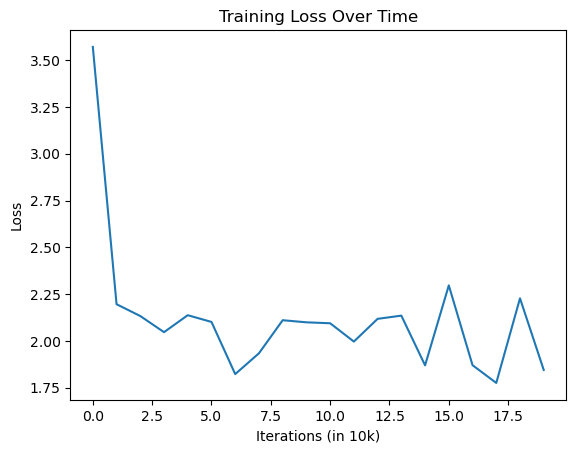

In [12]:
# Plot the loss over time
plt.plot(lossi)
plt.xlabel('Iterations (in 10k)')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

In [13]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    return loss.item()

print('Training loss:', split_loss('train'))
print('Validation loss:', split_loss('val'))
print('Test loss:', split_loss('test'))

Training loss: 1.9417736530303955
Validation loss: 2.0670723915100098
Test loss: 2.0764963626861572


In [14]:
# sample from the model
g = torch.Generator().manual_seed(2147 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carie.
maisibea.
sten.
likaley.
caporia.
jaylynn.
alua.
kamrem.
avrahmire.
isze.
jensraelailana.
monia.
marius.
turserrita.
domin.
baira.
binna.
umarie.
reiana.
avia.


In [15]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.060652017593384
val 2.117051362991333
